In [1]:
from modularity import Hessian
from modularity.resnet_model import ResNetModel
from pathlib import Path

model = ResNetModel.load_from_checkpoint(
    Path.home() / "modularity-logs" / "lightning_logs" / "sd-0.1-1.6gf" / "checkpoints" / "epoch=99-step=39100.ckpt",
    num_classes=10
)

In [2]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision as tv

val_transform = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
        tv.transforms.Normalize([0, 0, 0], [1, 1, 1]),
    ]
)

val = tv.datasets.CIFAR10(
    "cifar10_val", train=False, download=True, transform=val_transform
)
val_dl = DataLoader(val, batch_size=128, num_workers=8)
hess = Hessian(model.resnet.cuda(), F.cross_entropy, dataloader=val_dl)

Files already downloaded and verified


In [3]:
eigval, eigvec = hess.topk_eig()

Power iteration:   0%|          | 0/100 [00:00<?, ?it/s]

/home/norabelrose/miniforge3/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/autograd/engine.cpp:985.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [4]:
out = hess.density()

Lanczos quadrature:   0%|          | 0/100 [00:00<?, ?it/s]

/home/norabelrose/modularity/modularity/hessian.py:319: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  a_, b_ = torch.eig(T, eigenvectors=True)


In [9]:
import matplotlib.pyplot as plt
import numpy as np


def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvalue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.tight_layout()
    # plt.savefig('example.pdf')


def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

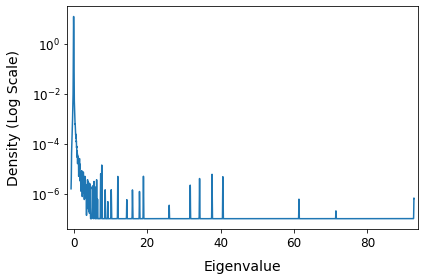

In [10]:
get_esd_plot(*out)

In [2]:
sum(param.numel() for param in regnet.parameters())

5495976

In [22]:
from torchvision.models.regnet import ResBottleneckBlock
from types import MethodType
import torch as th
import torchvision as tv

def patched_forward(self, x: th.Tensor) -> th.Tensor:
    diff = tv.ops.stochastic_depth(self.f(x), 0.1, 'row', self.training)
    if self.proj is not None:
        x = self.proj(x) + diff
    else:
        x = x + diff

    return self.activation(x)

for mod in regnet.modules():
    if not isinstance(mod, ResBottleneckBlock):
        continue

    mod.forward = MethodType(patched_forward, mod)

In [23]:
regnet(th.randn(1, 3, 224, 224, device='cuda'))

tensor([[ 5.5444e-01, -5.1184e-02, -6.6204e-01,  2.1447e-01, -1.6160e-01,
         -2.2837e-01, -1.9528e-01, -9.5886e-02,  3.7502e-01, -6.9556e-01,
         -5.3866e-01,  3.7680e-01, -4.4030e-01,  2.6729e-01,  1.0549e+00,
          5.9788e-01, -3.1261e-01, -9.8664e-02, -2.4541e-01,  1.2788e-01,
         -3.3950e-02,  2.2244e-01,  3.9714e-01,  3.8603e-02,  2.8211e-01,
          1.6807e-02,  7.2744e-01,  6.2274e-01, -3.3391e-01, -1.1544e+00,
         -4.4447e-01, -3.4525e-02,  4.7817e-01,  5.4359e-01, -1.0114e-01,
          7.5764e-01, -2.6496e-01,  7.7499e-01,  4.2054e-01, -4.8576e-01,
          1.0642e+00, -1.5733e-01, -1.8412e-01,  3.3416e-01,  3.2443e-01,
          2.7007e-01, -8.9121e-01, -3.8091e-01,  6.1517e-01, -6.2301e-02,
         -1.2033e-01,  3.7144e-01, -3.2188e-02,  4.4235e-02,  1.3679e-01,
         -3.1600e-01,  5.4691e-02,  1.3078e-02,  2.5632e-01, -2.7866e-01,
         -5.8663e-01, -3.7895e-01,  6.3106e-01,  3.0295e-03,  8.2799e-01,
         -4.6840e-01, -3.5479e-03,  2.

In [ ]:
import pytorch_lightning as pl


class 